---
# **データサイエンス基礎　第9回課題**
## **【時系列分析】季節自己回帰統合移動平均モデル(SARIMAx)を用いた日経平均株価終値の予測**
---
### 1. データの概要
　今回扱うデータは，[日経平均プロファイルダウンロードセンター](https://indexes.nikkei.co.jp/nkave/index?type=download)より得られる，[日経平均株価の日次データ](https://indexes.nikkei.co.jp/nkave/historical/nikkei_stock_average_daily_jp.csv)である．ここで，日経平均とは東京証券取引所プライム市場に上場する225銘柄を選定し，それらの株価を使って算出される株価平均型の指数である．  
　このcsv形式の時系列データを処理して，日経平均株価を予測するSARIMAモデルを作成する．
### 2. 日経平均株価の時系列データの特徴を分析
　まず，データより (1) <u>時系列グラフを描画</u> した後，(2) <u>自己相関係数および偏自己相関係数を計算し，95 % 信頼区間とともに描画する（Ljung-Box検定）</u>．最後に，時系列データを (3) <u>トレンド＋規則的変動成分＋不規則変動成分に分解する</u>．  
#### (1) 時系列グラフの描画
　取得したCSVデータは，最終行に説明文が記録されている．データの読み込み部分ではこれを除外する．また，エンコード方法が異なり，文字化けが発生してしまう問題もあり，これについては，読み込みの引数を変えるよりも，CSVデータのエンコード方法自体を変更した．

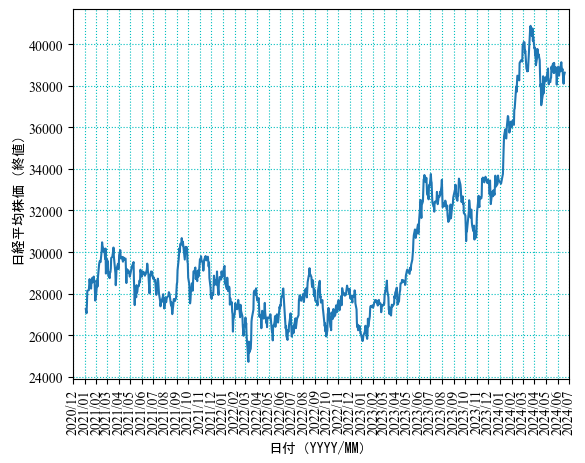

In [2]:
# ライブラリの読み込み
# %pip install --upgrade pip
# %pip install numpy
# %pip install matplotlib
# %pip install pandas
# %pip install openpyxl
# %pip install sympy
# %pip install scipy
# %pip install re
# %pip install jaconv
# %pip install scikit-learn
# %pip install statsmodels
# %pip install seaborn
# %pip install pmdarima
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from matplotlib.font_manager import FontProperties
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import random
import sympy as sp
import scipy.stats as stats
import re
import jaconv 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
import itertools
import matplotlib.dates as mdates
import pmdarima as pm
from IPython.display import clear_output
from sklearn.metrics import r2_score


# 日経平均株価のデータフレーム
df = pd.read_csv('nikkei_stock_average_daily_jp.csv', skipfooter=1, engine='python')
df['日付'] = pd.to_datetime(df['日付'])

# 日経平均株価の時系列グラフを描画
fig = plt.figure()  
ax = fig.add_subplot(111)
ax.plot(df['日付'], df['終値'])
start_date = pd.Timestamp('2020-12-01')
end_date = pd.Timestamp('2024-07-01')
ax.set_xlim(start_date, end_date)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m'))
plt.setp(ax.get_xticklabels(), rotation=90, ha='center')
ax.grid(axis='both',linestyle='dotted', color='c')
plt.xlabel('日付（YYYY/MM）', fontproperties={'family':'MS Gothic'})
plt.ylabel('日経平均株価（終値）', fontproperties={'family':'MS Gothic'})
plt.rcParams['font.family'] = 'Times New Roman'
plt.show()

#### (2) 自己相関係数および偏自己相関係数の値と 95 % 信頼区間

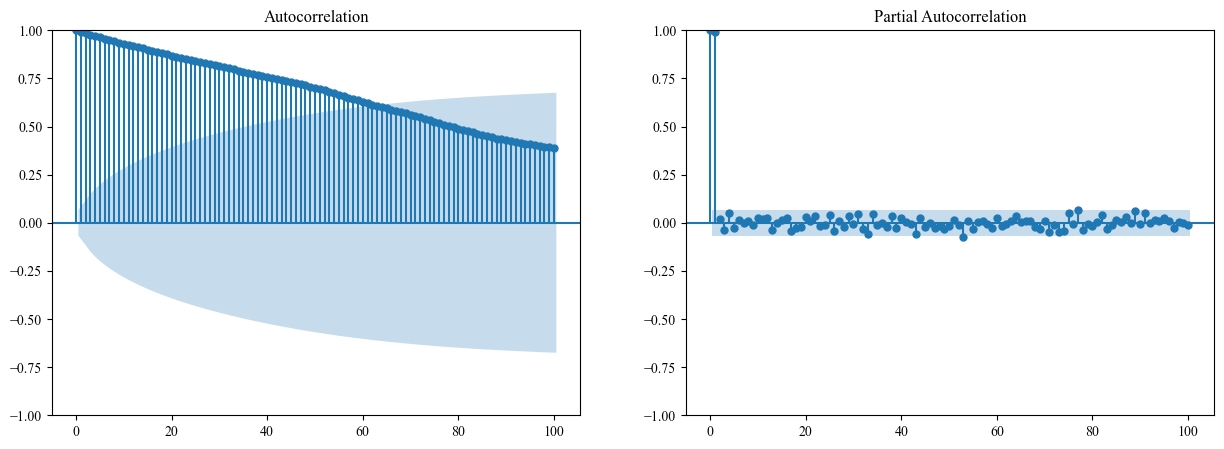

In [3]:
fig = plt.figure(figsize=(15, 5))  

# 自己相関係数のグラフを描画
ax1 = fig.add_subplot(121)
fig = sm.graphics.tsa.plot_acf(df['終値'], ax=ax1, lags=100)

# 偏自己相関係数のグラフを描画
ax2 = fig.add_subplot(122)
fig = sm.graphics.tsa.plot_pacf(df['終値'], ax=ax2, lags=100, method='ywm')

plt.show()

　したがって，日経平均株価は直近の値に有意な偏自己相関係数がある．

#### (3) 時系列データの分解（トレンド＋規則的変動成分＋不規則変動成分）

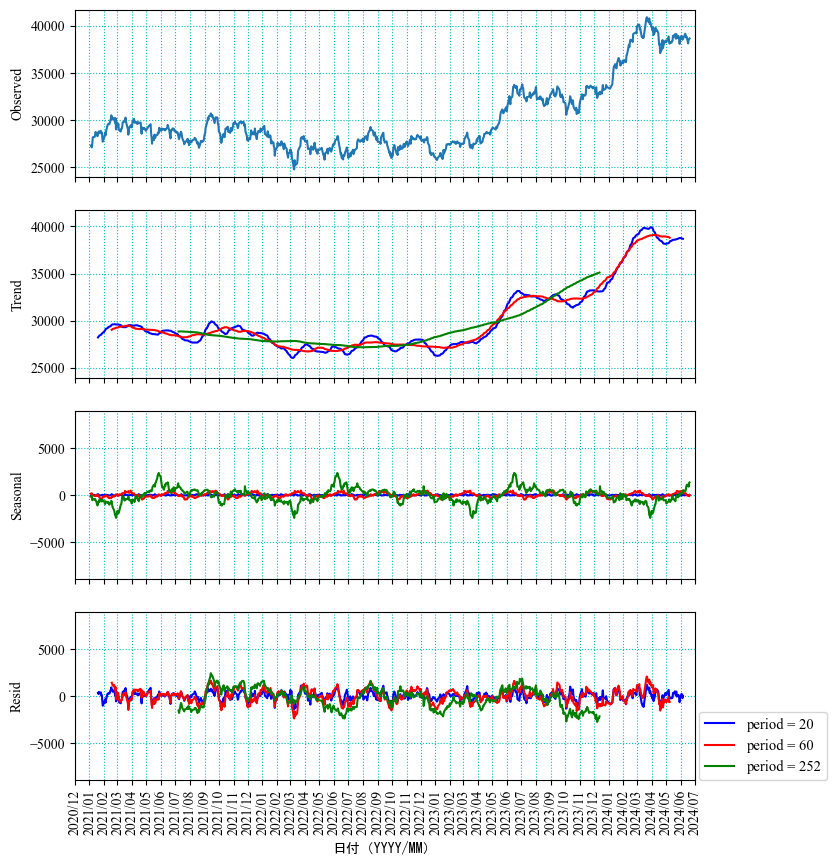

In [4]:
# 時系列データをトレンド，規則的変動成分，不規則変動成分に分解
fig = plt.figure(figsize=(8, 10))
start_date = pd.Timestamp('2020-12-01')
end_date = pd.Timestamp('2024-07-01')
ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)

color = ['blue', 'red', 'green']
for  index, period in enumerate([20, 60, 252]):
    result = sm.tsa.seasonal_decompose(df['終値'], period=period) 

    # 時系列データの描画
    if index == 0:
        ax1.set_ylabel('Observed')
        ax1.plot(df['日付'], result.observed)
        ax1.set_xlim(start_date, end_date)
        ax1.xaxis.set_major_locator(mdates.MonthLocator())
        ax1.set_xticklabels([])
        y_min, y_max = ax1.get_ylim()

    # トレンドの描画
    ax2.set_ylabel('Trend')
    ax2.plot(df['日付'], result.trend, color=color[index])
    ax2.set_xlim(start_date, end_date)
    ax2.xaxis.set_major_locator(mdates.MonthLocator())
    ax2.set_xticklabels([])
    ax2.set_ylim(y_min, y_max)

    # 規則的変動成分の描画
    ax3.set_ylabel('Seasonal')
    ax3.plot(df['日付'], result.seasonal, color=color[index])
    ax3.set_xlim(start_date, end_date)
    ax3.xaxis.set_major_locator(mdates.MonthLocator())
    ax3.set_xticklabels([])
    ax3.set_ylim(-(y_max - y_min) / 2, (y_max - y_min) / 2)

    # 不規則変動成分の描画
    ax4.set_ylabel('Resid')
    ax4.plot(df['日付'], result.resid, color=color[index], label=f'period = {period}')
    ax4.set_xlim(start_date, end_date)
    ax4.xaxis.set_major_locator(mdates.MonthLocator())
    ax4.xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m'))
    plt.setp(ax4.get_xticklabels(), rotation=90, ha='center')
    ax4.set_ylim(-(y_max - y_min) / 2, (y_max - y_min) / 2)
    ax4.legend(loc='upper center', bbox_to_anchor=(1.11, 0.45), prop={'size': 10.5})

ax1.grid(axis='both',linestyle='dotted', color='c')
ax2.grid(axis='both',linestyle='dotted', color='c')
ax3.grid(axis='both',linestyle='dotted', color='c')
ax4.grid(axis='both',linestyle='dotted', color='c')
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.xlabel('日付（YYYY/MM）', fontproperties={'family':'MS Gothic'})
plt.show()

　したがって，周期の値によって，成分の分解結果が異なり，最も確からしい周期を決定することが重要であると考えられる．

### 3. 時系列モデルのパラメータ推定

#### (1) データの分割（学習用と検証用）


In [5]:
# 学習用：検証用 = 4：1 の比率でデータを分割
train_size = int(len(df) * 0.8)
train = df.iloc[:train_size]['終値']
test = df.iloc[train_size-1:]['終値']

#### (2) 季節自己回帰統合移動平均モデル(SARIMAx)のパラメータを自動探索


In [7]:
# SAVE DATA
# >> Period: 286/424, Now Best Period: 74, AIC: 9678.110134543196 	Learning Best SARIMA Model ...
# >> Periods: [92, 136, 144, 147, 192, 194, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285] can not be completed.

AIC_min = np.inf 
best_period = 74 # 2 
error_period = []

# SARIMA の最適次数（季節成分）を探索
for period in range(1, int(len(df)/2)): # 149
    print(f'>> Period: {period}/{int(len(df)/2)}, Now Best Period: {best_period}, AIC: {AIC_min} \tLearning Best SARIMA Model ...\n', end='', flush=True)
    print(f'>> Periods: {error_period} can not be completed.')

    try:
        # ARIMA パラメータの探索
        model = pm.auto_arima(train, seasonal=True, m=period, stepwise=True, trace=True)

        # 情報量基準（AIC）による判定
        if AIC_min > model.aic():
            AIC_min = model.aic()
            best_period = period
        
        clear_output(wait=True)
    
    except:
        clear_output(wait=True)
        error_period.append(period)
        continue

exog = ['始値','高値','安値']                       # 外生変数の候補を格納するリスト
combinations = []                                  # 外生変数の組み合わせを格納するリスト
best_exog = 'NULL'
error_exog = []

# 外生変数の全ての組み合わせを用意
combinations.append('NULL')
for r in range(1, len(exog) + 1):
    combo = list(itertools.combinations(exog, r))
    combinations.extend(combo)

# SARIMAx の最適次数（外生変数）を探索
for exog in combinations:
    print(f'>> Exogenous: {exog}/{len(combinations)}, Now Best Exogenous: {best_exog}, AIC: {AIC_min} \tLearning Best SARIMAx Model ...\n', end='', flush=True)
    print(f'>> Exogenous: {error_exog} can not be completed.')

    if exog == 'NULL':
        df_exog = False
    else:
        df_exog = df[list(exog)]

    try:
        # ARIMA パラメータの探索
        model = pm.auto_arima(train, exogneous=df_exog, seasonal=True, m=best_period, stepwise=True, trace=True)

        # 情報量基準（AIC）による判定
        if AIC_min > model.aic():
            AIC_min = model.aic()
            best_exog = exog
        
        clear_output(wait=True)
    
    except:
        clear_output(wait=True)
        error_exog.extend(exog)
        continue

print('>> Completed ! <<')
print(f'>> Best Parameters [Period: {best_period}, Exogenous: {best_exog}]')
print('< Errors >')
print(f'>> Periods: {error_period} can not be completed.')
print(f'>> Exogenous: {error_exog} can not be completed.')

>> Completed ! <<
>> Best Parameters [Period: 74, Exogenous: NULL]
< Errors >
>> Periods: [] can not be completed.
>> Exogenous: [] can not be completed.



#### (3) 最適な時系列モデル（探索結果）の出力


In [5]:
best_exog = 'NULL'
best_period = 74
if best_exog == 'NULL':
    df_best_exog = None
else:
    df_best_exog = df[list(best_exog)]

best_model = pm.auto_arima(train, exogenous=df_best_exog, seasonal=True, m=best_period, stepwise=True, trace=False)

best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  679
Model:             SARIMAX(0, 1, 0)x(1, 0, 0, 74)   Log Likelihood               -4891.711
Date:                            Thu, 20 Jun 2024   AIC                           9787.422
Time:                                    19:24:39   BIC                           9796.460
Sample:                                         0   HQIC                          9790.921
                                            - 679                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L74      -0.1110      0.039     -2.845      0.004      -0.187      -0.035
sigma2      1.064e+05   5510.388     19.317      0.000    9.56e+04    1.17e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):                 3.21
Prob(Q):                              0.65   Prob(JB):                         0.20
Heteroskedasticity (H):               0.78   Skew:                            -0.15
Prob(H) (two-sided):                  0.06   Kurtosis:                         3.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 4. 時系列モデルによって将来のデータを予測

#### (1) 将来データの推定


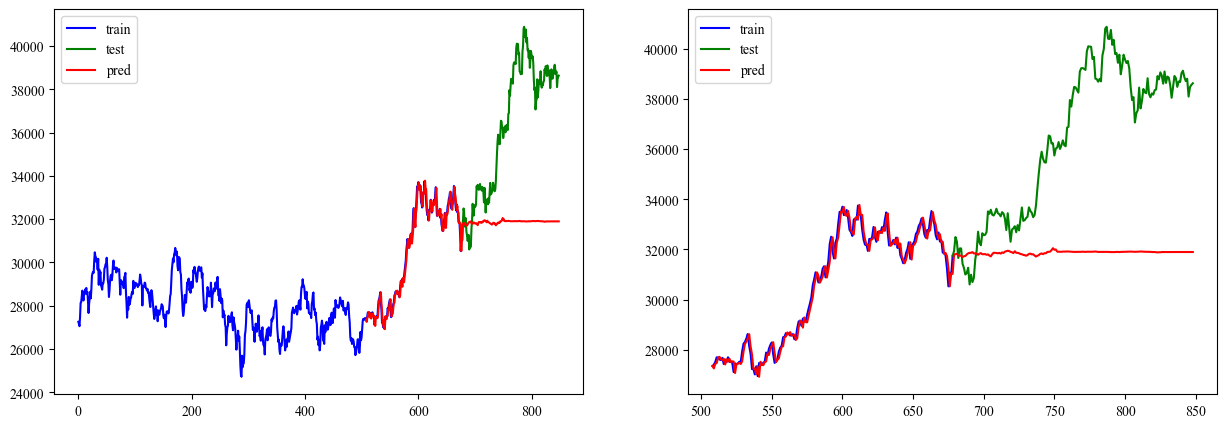

In [6]:
# 探索した最適次数を利用して SARIMAx モデルを作成
SARIMAx = sm.tsa.SARIMAX(train, exog=df_best_exog, order=best_model.order, seasonal_order=best_model.seasonal_order).fit()
pred = SARIMAx.predict(train_size-len(test), len(df)-1)

# 予測結果の可視化
fig = plt.figure(figsize=(15, 5))  
ax1 = fig.add_subplot(121)
ax1.plot(train, 'blue', label='train')
ax1.plot(test, 'green', label='test')
ax1.plot(pred, 'red', label='pred')
ax1.legend()
ax2 = fig.add_subplot(122)
ax2.plot(train[train_size-len(test):], 'blue', label='train')
ax2.plot(test, 'green', label='test')
ax2.plot(pred, 'red', label='pred')
ax2.legend()


#### (2) 推定値の評価

In [7]:
# 各区間の予測値
pred_train = SARIMAx.predict(0, train_size-1)
pred_test = SARIMAx.predict(train_size-1, len(df)-1)

# R^2値（寄与率）を計算
r2_train = r2_score(train, pred_train)
r2_test = r2_score(test, pred_test)

# 学習区間の数日後の推定値における相対誤差
print(f'R^2 Score [train: {r2_train:.3f}, test: {r2_test:.3f}]')
for i in range(10):
    error = (SARIMAx.predict(train_size-1+i).values[0] - test.iloc[i]) / test.iloc[i] * 100
    print(f'Relative Error After {i+1} Day : {error:.2f} %')

R^2 Score [train: 0.657, test: -2.206]
Relative Error After 1 Day : -2.26 %
Relative Error After 2 Day : -0.43 %
Relative Error After 3 Day : -2.11 %
Relative Error After 4 Day : -1.51 %
Relative Error After 5 Day : 0.30 %
Relative Error After 6 Day : -0.91 %
Relative Error After 7 Day : -0.90 %
Relative Error After 8 Day : 0.83 %
Relative Error After 9 Day : 1.50 %
Relative Error After 10 Day : 2.38 %


#### (3)  $N$ 日後の日経平均株価を予測

In [8]:
# 何日後まで予測するかを指定
N = 5

# モデルの区間を拡張し，最適次数を用いて新たなモデルを作成
train_all = df['終値']
SARIMAx = sm.tsa.SARIMAX(train_all, exog=df_best_exog, order=best_model.order, seasonal_order=best_model.seasonal_order).fit()

# N日後の日経平均株価を予測
for i in range(N):
    pred = SARIMAx.predict(len(train_all) + 1 + i)
    print(f'After {i+1} Day : {pred.values[0]:.2f}')


After 1 Day : 38635.05
After 2 Day : 38689.26
After 3 Day : 38679.32
After 4 Day : 38775.00
After 5 Day : 38777.53


### 感想  
　autoARIMA()関数に対して，周期や外生変数の条件を繰り返し試すと，機械学習並みにメモリと時間を要した．その割には，推定精度が悪かった．これは，autoARIMA()関数がAICの最適化を図っていることが1つの原因であり，これによってモデルが過学習したことが考えられる．推定精度を上げるためには，モデルの評価手法を工夫することが必要である．
　